# Coursera Capstone Project – Battle of Neighbourhoods
## French restaurants in New York City
#### Raphaelle Thervet


## 1.	Introduction:

### 1.1.	Background

New York City, one of the biggest cities in the United States and one of the liveliest, has always been known for their restaurants, who are happy to serve both residents as well as tourists. There are more than 27,043 restaurants in New York City, which makes the competition very hard, and it will become more and more fierce once restaurants will be able to reopen, after quarantine is over. French Cuisine has always been of interests for Americans, and it has been back in style in recent years. Many French cooks, such as Alain Ducasse or Gilles Verot, have open restaurant in the Big Apple, and their restaurants are almost always full of reservations. 

### 1.2.	Problem

Using analytics, restaurants are able to make strategic decisions based on insights gained on a specific region or city. Because of the high price of the menus, that often comes in hand with the sophistication of this cuisine, it is of utmost important to find the right place for people to come and eat. Therefore, this project will be able to identify an ideal business location for a French restaurant by considering areas that have a high frequency of residents, but a low frequency of other French restaurants. 

### 1.3.	Interest

Obviously, a restaurant owner looking to open a new French restaurant will be the primary target for this project. But this project can also serve the purpose of answering the question: “where is the best place to stay, in order to enjoy French cuisine?”. The methodology could also be replicable for any kind of restaurants or cuisine. 

## 2.	Data acquisition

In order to do so, I will need to access the following data: 

•	The main data resource will come from the Foursquare API. It will allow to find and filter all the different French restaurants in each neighbourhood. With this API, I will be able to also find ratings, tips, and like count for each restaurant. 

•	A New York City data (https://cocl.us/new_york_dataset) that contains list of Boroughs and neighbourhoods, along with their latitude and longitude, to explore the various neighbourhoods of New York City.
•	A scraping from Wikipedia  (https://en.wikipedia.org/wiki/Neighborhoods_in_
New_York_City)  will also be useful to find the population in each neighbourhood.

•	The Geospace data  (https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) will be useful to create boundaries between the borough, to have a better visualization on maps created. 
![image.png]

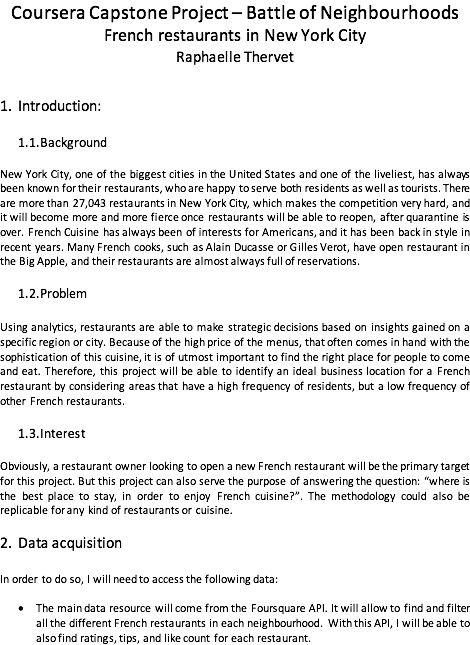

## 3. Methodology


### 3.1 Approach

First, I collected the New York City data, to better understand the different neighbourhoods and boroughs. I then use the Foursquare API to find all the venues and filter to only the French restaurants. Then I connected with the API to find the ratings, tips and like count for each restaurant. I sorted the data according to the rating, which is the most important factor, and then I visualize that ranking compared to the neighbourhoods using the folium library.

### 3.2 Analysis

First, let's import the required libraries in pyhton. \
        • pandas and numpy for data handling \
        • request module for using Foursquare API  \
        • geopy to get the right coordinates \
        • folium to visualize in a map at the end

In [1]:
# import the necessary package

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup
!conda install -c conda-forge lxml --yes
!pip install geopy
from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
import os
import folium # map rendering library
import json # library to handle JSON files


# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.4.5~ --> anaconda::ca-certificates-2020.1.1-0
  certifi            conda-forge::certifi-2020.4.5.1-py36h~ --> anaconda::certifi-2020.4.5.1-py36_0
  openssl            conda-forge::openssl-1.1.1g-h516909a_0 --> anaconda::openssl-1.1.1g-h7b6447c_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - lxml


The following packages will be UPDATED:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi 

Now we define a function to get the latitudes and longitudes of the different neighbourhoods in NYC.

In [2]:
# @hidden_cell
CLIENT_ID = 'KRAVEI2Z01XKQS4FJ4OH2KWHRHJCHQMGKXZNG4YVNPJPQEW2'
CLIENT_SECRET = 'JDCXPOGBS0OCYLJNJGDP5KPIVEIZV2OWI32TTKDDYHI5LBQ5'
VERSION = '20180604'

We define all the different functions that we will be using later on

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Let's have a first look at the ny data

In [4]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
new_york_data.shape

(306, 4)

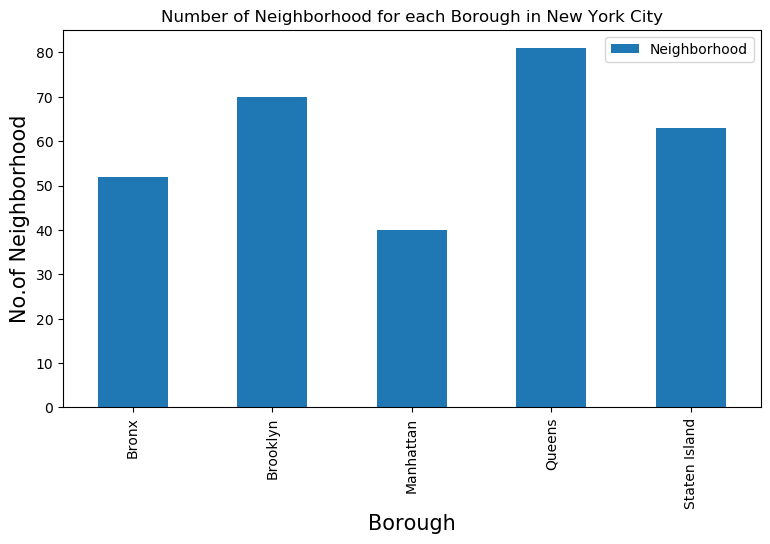

In [6]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the most number of neighborhoods. Let's now better understand where the french restaurants are located. 

In [ ]:
# prepare neighborhood list that contains french resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
fr_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_restaurants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Restaurants in '+Neighborhood+', '+Borough+':'+str(len(french_restaurants)))
    for restaurant_detail in french_restaurants.values.tolist():
        id, name , category=restaurant_detail
        fr_rest_ny = fr_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Restaurants in Wakefield, Bronx:0
( 2 / 306 ) French Restaurants in Co-op City, Bronx:0
( 3 / 306 ) French Restaurants in Eastchester, Bronx:0
( 4 / 306 ) French Restaurants in Fieldston, Bronx:0
( 5 / 306 ) French Restaurants in Riverdale, Bronx:0
( 6 / 306 ) French Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) French Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) French Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) French Restaurants in Norwood, Bronx:0
( 10 / 306 ) French Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) French Restaurants in Baychester, Bronx:0
( 12 / 306 ) French Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) French Restaurants in City Island, Bronx:1
( 14 / 306 ) French Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) French Restaurants in University Heights, Bronx:0
( 16 / 306 ) French Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) French Restaurants in Fordham, Bronx:0
( 18 / 306 ) French Restaurants in East Tremont, Bronx:

In [ ]:
fr_rest_ny.head()
fr_rest_ny.shape

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=15)
#giving a bar plot
fr_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=15)
#giving a bar plot
fr_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Therefore, most restaurants are in XXX borough and in XX neighborhood. 

Let's dig deeper into all the restaurants. 

In [ ]:
fr_rest_ny[fr_rest_ny['Neighborhood']=='Upper East Side']


In [ ]:

# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
fr_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in fr_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(fr_rest_ny),')','processed')
    fr_rest_stats_ny = fr_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [ ]:
fr_rest_stats_ny.head()



We have the data for all resturants. We want to save this data to a csv sheet, in case we by mistake modify it. Also, as the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [ ]:
fr_rest_stats_ny.to_csv('fr_rest_stats_ny.csv', index=False)


In [ ]:
fr_rest_stats_ny_csv=pd.read_csv('fr_rest_stats_ny.csv')


In [ ]:
fr_rest_stats_ny_csv.head()


In [ ]:
fr_rest_stats_ny.info()

We need to clean the data a little bit, bu changing the nature of Likes, Tips and Ratings to float type. 

In [ ]:
fr_rest_stats_ny['Likes']=fr_rest_stats_ny['Likes'].astype('float64')


In [ ]:
fr_rest_stats_ny['Tips']=fr_rest_stats_ny['Tips'].astype('float64')


In [ ]:
fr_rest_stats_ny.describe()

In [ ]:
# Restaurant with maximum Likes
fr_rest_stats_ny.iloc[fr_rest_stats_ny['Likes'].idxmax()]

In [ ]:
fr_rest_stats_ny.iloc[fr_rest_stats_ny['Tips'].idxmax()]

In [ ]:
fr_rest_stats_ny.iloc[fr_rest_stats_ny['Rating'].idxmax()]

We can now visualize neighborhood with the maximum average rating of restaurants

In [ ]:
ny_neighborhood_stats=fr_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [ ]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of French Resturants for each Neighborhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
fr_rest_stats_ny.groupby('Neighborhood').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
ny_borough_stats=fr_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of French Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
fr_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]


In [ ]:
ny_neighborhood_stats

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Let's see that on a map

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [ ]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGnBu',
    fill_opacity=0.6, 
    line_opacity=0.4,
    legend_name='Average Rating'
)

#display map
# the map is too huge so we have to save it to a file
ny_map.save('rated-map.html')

Click to [here](here.html) to find the map

## 4.	Conclusion:

### 4.1 Results


First, we can see that Queens is the borough with the highest number of neighbourhoods. 

But most French restaurants are located in Manhattan, despite having the least number of neighbourhoods in all five boroughs, especially in the Upper East Side. Manhattan and Brooklyn have the best rated French restaurants on average. Queens and The Bronx have the least number of French restaurants per neighbourhood.

We can also see that most restaurants are also highly rated, with more than 50% of all French restaurants with a rating higher than 8.2. 

More specifically, the highest average rating for French restaurant are located in East Harlem, and more broadly in Manhattan. 

Here is the map with the best neighbourhoods in New York that has highest average rating for French Restaurants.

Finally, here is the final Borough Choropleth map based on average rating of French Restaurants.



### 4.2 Recommandations

Based on this information, I would state that Manhattan and Brooklyn are the best locations for French cuisine in NYC. To have the best shot at success, I would open a French restaurant in Brooklyn, because it has multiple neighbourhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and it doesn’t have a high number of French restaurants, making competition easier than in other boroughs. Also, Queens has the lowest average ratings of French restaurants, so it can be good to look into opening a restaurant there, since competition will be bad. 
If you just want to have the best French Cuisine, you should go to Buvette or Mountain Bird or just stay in Manhattan, especially in East Harlem or the West Village. 


### 4.3 Limitation

All of the above analysis is dependent of the accuracy of Foursquare data. I also think that they are not enough French restaurants in New York for the analysis to be very insightful. It could be food to use other location data source, such as Google Place API. Moreover, the whole analysis is based solely on ratings, which may not be the best predicator.  A more comprehensive analysis and future work would need to incorporate data from other external databases.

### 4.4 Final conclusion

To conclude, this project has shown me how to answer a business problem analytically. We can say that Brooklyn is the best location for a new French restaurant, but it is better to stay in Manhattan to enjoy great French Cuisine. This project offers a great way to understand the many data provided by Foursquare. It can be easily applicable to different kind of problem, and does not limit itself to French restaurants. It can be a great tool for every kind of venue. Hopefully, venues will reopen soon, once the pandemic is over, so I will be able to use it on new and different datasets, to answer new business problem that could interest me.